In [3]:
!pip install torch torchvision torchaudio timm tqdm scikit-learn matplotlib seaborn pandas

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gc

# 1. Konfigurasi Global & Setup Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5
IMAGE_SIZE = 224

NUM_SAMPLES_TRAIN = 800
NUM_SAMPLES_TEST = 200

print(f"Device: {DEVICE}")
print(f"Image Size: {IMAGE_SIZE}, Batch Size: {BATCH_SIZE}")
print(f"Eksperimen menggunakan total {NUM_SAMPLES_TRAIN + NUM_SAMPLES_TEST} sampel data.")

Device: cuda
Image Size: 224, Batch Size: 16
Eksperimen menggunakan total 1000 sampel data.


In [5]:
# 2. DATA LOADING, PREPROCESSING, DAN DATALOADER SETUP

# Define normalization constants for CIFAR-10
NORMALIZE_MEAN = (0.4914, 0.4822, 0.4465)
NORMALIZE_STD = (0.2023, 0.1994, 0.2010)

# Transformasi Data
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

# Menggunakan CIFAR-10
print("\nLoading CIFAR-10 Dataset (Otomatis Download)...")
original_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
original_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Proses Pengurangan Dataset (Subset)
indices_train = torch.randperm(len(original_train_dataset))[:NUM_SAMPLES_TRAIN]
train_dataset = Subset(original_train_dataset, indices_train)

indices_test = torch.randperm(len(original_test_dataset))[:NUM_SAMPLES_TEST]
test_dataset = Subset(original_test_dataset, indices_test)

CLASS_NAMES = original_train_dataset.classes

# DataLoaders (dengan pin_memory=True untuk kecepatan GPU)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Jumlah Kelas: {NUM_CLASSES}")
print(f"Jumlah data training (Subset): {len(train_dataset)} sampel")
print(f"Jumlah data testing (Subset): {len(test_dataset)} sampel")


Loading CIFAR-10 Dataset (Otomatis Download)...


100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Jumlah Kelas: 10
Jumlah data training (Subset): 800 sampel
Jumlah data testing (Subset): 200 sampel


In [6]:
# 3. FUNGSI INISIASI MODEL & PENGHITUNGAN PARAMETER

def create_model(model_type, num_classes, pretrained=True):
    """Membuat model ViT atau Swin Transformer dari timm dan menghitung parameter."""

    if model_type == 'ViT':
        # Menggunakan nama standar model base, resolusi diatur via img_size
        model_name = 'vit_base_patch16_224'
    elif model_type == 'Swin':
        # Menggunakan nama standar model base
        model_name = 'swin_base_patch4_window7_224'
    else:
        raise ValueError("Model type not supported.")

    try:
        model = timm.create_model(model_name,
                                 pretrained=pretrained,
                                 num_classes=num_classes,
                                 img_size=IMAGE_SIZE) # Ini yang menyesuaikan ukuran input

        # Pindahkan Model ke Device
        model = model.to(DEVICE)

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        model_size_mb = (total_params * 4) / (1024 * 1024)

        print(f" Model {model_type} ({model_name})")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Model Size (MB): {model_size_mb:.2f}")

        return model, total_params, model_size_mb

    except Exception as e:
        print(f"Error creating model {model_type}: {e}")
        return None, 0, 0

In [7]:
# 4. FUNGSI VISUALISASI METRIK (LEARNING CURVE & CONFUSION MATRIX)

def plot_metrics(history, conf_matrix, model_name, class_names):
    """Memvisualisasikan Learning Curve dan Confusion Matrix."""

    # Plot Learning Curve (Loss dan Accuracy)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Learning Loss Curve (5 Epochs)'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} Learning Accuracy Curve (5 Epochs)'); plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend()
    plt.show()

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title(f'{model_name} Confusion Matrix')
    plt.show()


In [8]:
# 5. FUNGSI TRAINING DAN EVALUASI

def train_and_evaluate_model(model, model_name, train_loader, test_loader):
    """Melakukan fine-tuning, evaluasi, dan pengukuran metrik."""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"Memulai Fine-Tuning untuk {model_name} ({NUM_EPOCHS} epochs) ")

    # Training Loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Train)"):
            # DATA DIPINDAHKAN KE GPU
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_loss); history['train_acc'].append(epoch_acc)

        # Validation Loop
        model.eval()
        val_loss = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0); correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Kosongkan cache GPU dan memori Python (Optimasi VRAM/RAM)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()


    # Pengukuran Metrik Inferensi Akhir
    print(f" Pengukuran Metrik Akhir dan Inferensi untuk {model_name} ")

    all_preds = []; all_labels = []; total_time = 0; total_samples = 0

    print("Warming up for stable timing...")
    with torch.no_grad():
        for _ in range(10):
            try: model(next(iter(test_loader))[0].to(DEVICE))
            except StopIteration: break

    # Pengukuran Waktu Inferensi
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Mengukur Inferensi"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()
            total_time += (end_time - start_time)
            total_samples += inputs.size(0)
            # Prediksi dipindahkan kembali ke CPU untuk perhitungan metrik
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Perhitungan Metrik
    avg_inference_time_ms = (total_time / total_samples) * 1000
    throughput = total_samples / total_time
    accuracy = accuracy_score(all_labels, all_preds)

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # OUTPUT DATA
    print(f"\n[HASIL INFERENSI {model_name}]")
    print(f"Waktu Inferensi Rata-rata per Gambar: {avg_inference_time_ms:.3f} ms")
    print(f"Throughput: {throughput:.2f} gambar/detik")

    print(f"\n[HASIL PERFORMA {model_name}]")
    print(f"Accuracy Keseluruhan: {accuracy*100:.2f}%")
    print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1-Score: {f1_macro:.4f}")

    print("\nMetrik Per Kelas :")
    for i, name in enumerate(CLASS_NAMES):
        print(f"   {name}: P={precision_per_class[i]:.4f}, R={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

    # Visualisasi
    plot_metrics(history, conf_matrix, model_name, CLASS_NAMES)

    return {
        'accuracy': accuracy,
        'macro_f1': f1_macro,
        'inf_time_ms': avg_inference_time_ms,
        'params_total': None,
        'size_mb': None
    }


======================================== MEMULAI EKSPERIMEN VIY ========================================



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

 Model ViT (vit_base_patch16_224)
Total Parameters: 85,806,346
Trainable Parameters: 85,806,346
Model Size (MB): 327.33
Memulai Fine-Tuning untuk ViT (5 epochs) 


Epoch 1/5 (Train): 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


[ViT] Epoch 1 - Train Loss: 1.2674, Val Loss: 0.4250, Train Acc: 62.12%, Val Acc: 87.00%


Epoch 2/5 (Train): 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


[ViT] Epoch 2 - Train Loss: 0.1288, Val Loss: 0.3023, Train Acc: 97.25%, Val Acc: 90.00%


Epoch 3/5 (Train): 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


[ViT] Epoch 3 - Train Loss: 0.0226, Val Loss: 0.2483, Train Acc: 99.88%, Val Acc: 91.50%


Epoch 4/5 (Train): 100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


[ViT] Epoch 4 - Train Loss: 0.0052, Val Loss: 0.2491, Train Acc: 100.00%, Val Acc: 91.50%


Epoch 5/5 (Train): 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


[ViT] Epoch 5 - Train Loss: 0.0030, Val Loss: 0.2487, Train Acc: 100.00%, Val Acc: 92.00%
 Pengukuran Metrik Akhir dan Inferensi untuk ViT 
Warming up for stable timing...


Mengukur Inferensi: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s]



[HASIL INFERENSI ViT]
Waktu Inferensi Rata-rata per Gambar: 0.720 ms
Throughput: 1388.81 gambar/detik

[HASIL PERFORMA ViT]
Accuracy Keseluruhan: 92.00%
Macro Precision: 0.9218, Macro Recall: 0.9089, Macro F1-Score: 0.9112

Metrik Per Kelas :
   airplane: P=0.9545, R=0.9545, F1=0.9545
   automobile: P=0.9615, R=1.0000, F1=0.9804
   bird: P=0.9048, R=0.9048, F1=0.9048
   cat: P=0.8182, R=0.9474, F1=0.8780
   deer: P=0.8000, R=1.0000, F1=0.8889
   dog: P=0.9091, R=0.7143, F1=0.8000
   frog: P=1.0000, R=0.9583, F1=0.9787
   horse: P=1.0000, R=0.7857, F1=0.8800
   ship: P=0.8696, R=0.8696, F1=0.8696
   truck: P=1.0000, R=0.9545, F1=0.9767


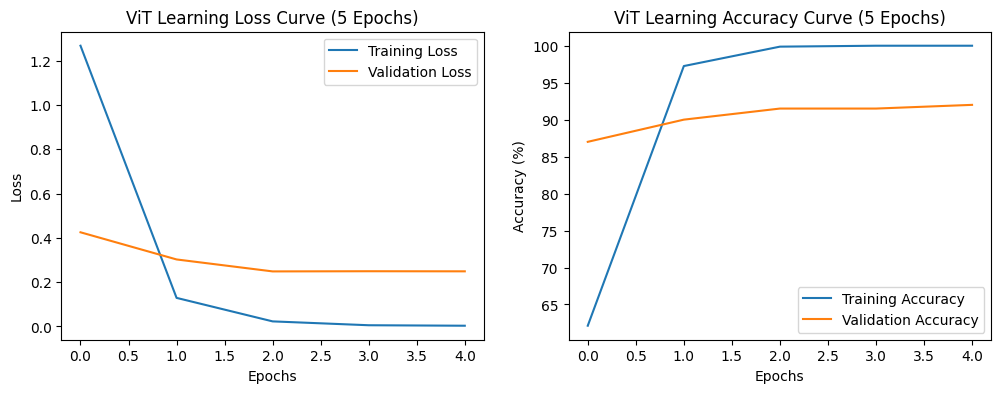

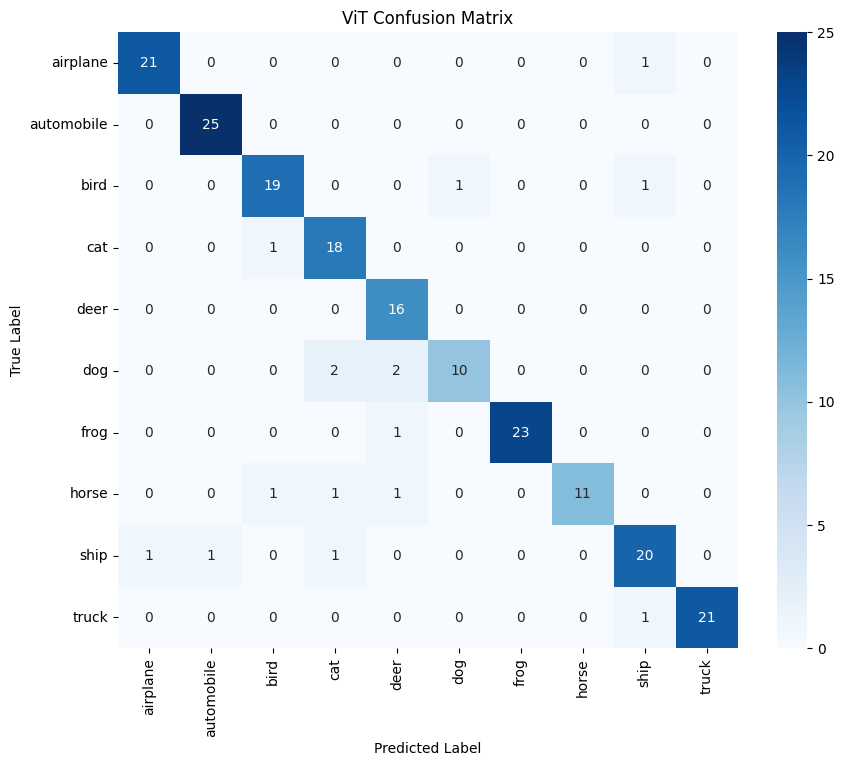


======================================== MEMULAI EKSPERIMEN SWIN ========================================



model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

 Model Swin (swin_base_patch4_window7_224)
Total Parameters: 86,753,474
Trainable Parameters: 86,753,474
Model Size (MB): 330.94
Memulai Fine-Tuning untuk Swin (5 epochs) 


Epoch 1/5 (Train): 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


[Swin] Epoch 1 - Train Loss: 2.0327, Val Loss: 1.4795, Train Acc: 35.38%, Val Acc: 72.00%


Epoch 2/5 (Train): 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


[Swin] Epoch 2 - Train Loss: 0.8454, Val Loss: 0.4393, Train Acc: 87.88%, Val Acc: 90.00%


Epoch 3/5 (Train): 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


[Swin] Epoch 3 - Train Loss: 0.2138, Val Loss: 0.2471, Train Acc: 96.62%, Val Acc: 93.00%


Epoch 4/5 (Train): 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


[Swin] Epoch 4 - Train Loss: 0.0829, Val Loss: 0.1926, Train Acc: 99.12%, Val Acc: 95.00%


Epoch 5/5 (Train): 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


[Swin] Epoch 5 - Train Loss: 0.0445, Val Loss: 0.1914, Train Acc: 99.62%, Val Acc: 93.50%
 Pengukuran Metrik Akhir dan Inferensi untuk Swin 
Warming up for stable timing...


Mengukur Inferensi: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]



[HASIL INFERENSI Swin]
Waktu Inferensi Rata-rata per Gambar: 2.524 ms
Throughput: 396.18 gambar/detik

[HASIL PERFORMA Swin]
Accuracy Keseluruhan: 93.50%
Macro Precision: 0.9324, Macro Recall: 0.9246, Macro F1-Score: 0.9258

Metrik Per Kelas :
   airplane: P=0.9545, R=0.9545, F1=0.9545
   automobile: P=1.0000, R=1.0000, F1=1.0000
   bird: P=1.0000, R=0.9524, F1=0.9756
   cat: P=0.8421, R=0.8421, F1=0.8421
   deer: P=0.7500, R=0.9375, F1=0.8333
   dog: P=0.8571, R=0.8571, F1=0.8571
   frog: P=1.0000, R=0.9167, F1=0.9565
   horse: P=1.0000, R=0.7857, F1=0.8800
   ship: P=0.9200, R=1.0000, F1=0.9583
   truck: P=1.0000, R=1.0000, F1=1.0000


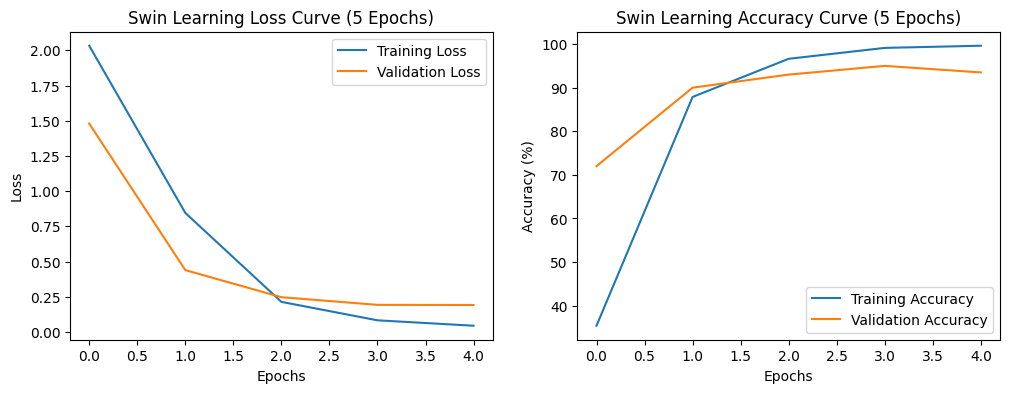

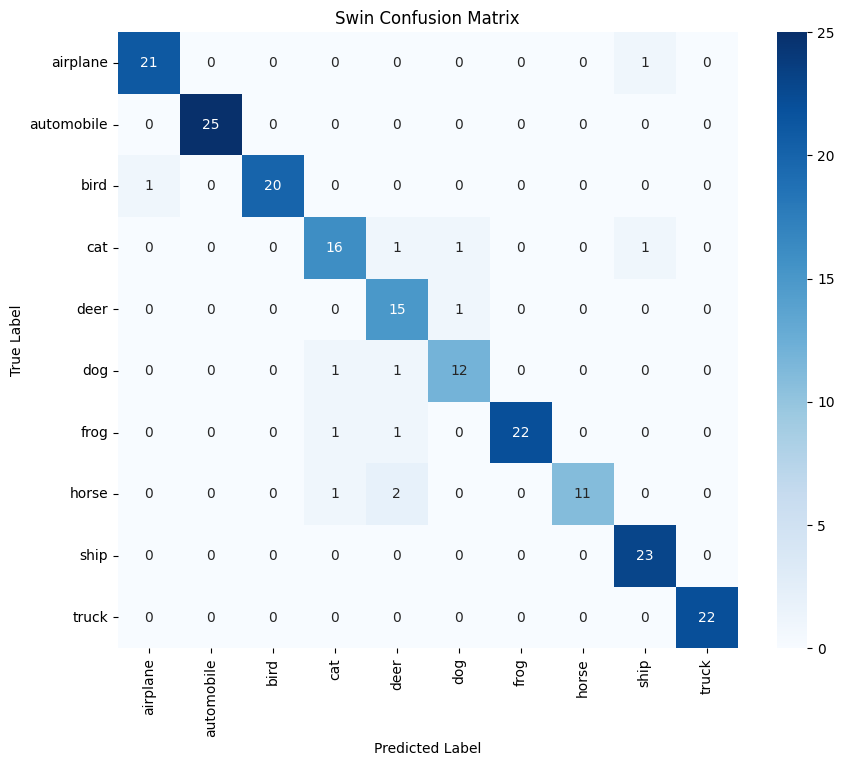


======================================== RINGKASAN KOMPARATIF AKHIR ========================================


[Tabel Komparatif Hasil Eksperimen]
| Model   |   Parameters (Juta) |   Size (MB) |   Accuracy (%) |   Macro F1 |   Inf Time/img (ms) |
|:--------|--------------------:|------------:|---------------:|-----------:|--------------------:|
| ViT     |             85.8063 |    327.3252 |        92.0000 |     0.9112 |              0.7200 |
| Swin    |             86.7535 |    330.9382 |        93.5000 |     0.9258 |              2.5241 |


Catatan Penting untuk Laporan:
Eksperimen menggunakan IMAGE_SIZE=224 dan BATCH_SIZE=16 untuk optimasi VRAM.


In [9]:
# 6. MAIN EXECUTION

if __name__ == "__main__":

    results = {}

    print("\n" + "="*40 + " MEMULAI EKSPERIMEN VIY " + "="*40 + "\n")
    # a. Implementasi dan Training Model ViT
    vit_model, vit_params, vit_size = create_model('ViT', NUM_CLASSES, pretrained=True)
    if vit_model:
        vit_metrics = train_and_evaluate_model(vit_model, 'ViT', train_loader, test_loader)
        vit_metrics['params_total'] = vit_params
        vit_metrics['size_mb'] = vit_size
        results['ViT'] = vit_metrics

    # Bebaskan memori GPU setelah ViT selesai
    del vit_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


    print("\n" + "="*40 + " MEMULAI EKSPERIMEN SWIN " + "="*40 + "\n")
    # b. Implementasi dan Training Model Swin Transformer
    swin_model, swin_params, swin_size = create_model('Swin', NUM_CLASSES, pretrained=True)
    if swin_model:
        swin_metrics = train_and_evaluate_model(swin_model, 'Swin', train_loader, test_loader)
        swin_metrics['params_total'] = swin_params
        swin_metrics['size_mb'] = swin_size
        results['Swin'] = swin_metrics

    del swin_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


    # --- Ringkasan Akhir untuk Laporan ---
    print("\n" + "="*40 + " RINGKASAN KOMPARATIF AKHIR " + "="*40 + "\n")

    data = []
    if 'ViT' in results:
        data.append({
            'Model': 'ViT',
            'Parameters (Juta)': results['ViT']['params_total'] / 1_000_000,
            'Size (MB)': results['ViT']['size_mb'],
            'Accuracy (%)': results['ViT']['accuracy'] * 100,
            'Macro F1': results['ViT']['macro_f1'],
            'Inf Time/img (ms)': results['ViT']['inf_time_ms']
        })
    if 'Swin' in results:
        data.append({
            'Model': 'Swin',
            'Parameters (Juta)': results['Swin']['params_total'] / 1_000_000,
            'Size (MB)': results['Swin']['size_mb'],
            'Accuracy (%)': results['Swin']['accuracy'] * 100,
            'Macro F1': results['Swin']['macro_f1'],
            'Inf Time/img (ms)': results['Swin']['inf_time_ms']
        })

    df_results = pd.DataFrame(data).set_index('Model')

    print("\n[Tabel Komparatif Hasil Eksperimen]")
    print(df_results.to_markdown(floatfmt=".4f"))

    print("\n\nCatatan Penting untuk Laporan:")
    print(f"Eksperimen menggunakan IMAGE_SIZE={IMAGE_SIZE} dan BATCH_SIZE={BATCH_SIZE} untuk optimasi VRAM.")